### CAPSTONE PROJECT 1 - PREDICTING THE HEALTH OF STREET TREES IN NEW YORK CITY

The documents describing this project can be found in the same repository.
The dataset used in this project has been downloaded locally and imported. It can be found at the following address:
https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

DATA WRANGLING AND CLEAN UP

In [1]:
# Import relevant modules
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import dataset
df=pd.read_csv('2015_Street_Tree_Census_Tree_Data.csv')
print('Dataset imported')

Dataset imported


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
tree_id             683788 non-null int64
block_id            683788 non-null int64
created_at          683788 non-null object
tree_dbh            683788 non-null int64
stump_diam          683788 non-null int64
curb_loc            683788 non-null object
status              683788 non-null object
health              652172 non-null object
spc_latin           652169 non-null object
spc_common          652169 non-null object
steward             652173 non-null object
guards              652172 non-null object
sidewalk            652172 non-null object
user_type           683788 non-null object
problems            652124 non-null object
root_stone          683788 non-null object
root_grate          683788 non-null object
root_other          683788 non-null object
trunk_wire          683788 non-null object
trnk_light          683788 non-null object
trnk_other          683788 non-nu

In [4]:
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,"4,073,900",New York,40.723092,-73.844215,"1,027,431.148","202,756.7687",29.0,739,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,"4,097,300",New York,40.794111,-73.818679,"1,034,455.701","228,644.8374",19.0,973,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.717581,-73.936608,"1,001,822.831","200,716.8913",34.0,449,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.713537,-73.934456,"1,002,420.358","199,244.2531",34.0,449,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,"3,016,500",New York,40.666778,-73.975979,"990,913.775","182,202.426",39.0,165,3025654.0,3.010850e+09


In [5]:
# Remove columns that aren't used or contains redundant information
drop_list=['tree_id','block_id','spc_latin','address','postcode','zip_city','community board','cncldist',
        'st_assem','st_senate','nta','boro_ct','state','x_sp','y_sp','council district','census tract',
        'bin','bbl']
df.drop(drop_list,axis=1,inplace=True)

In [6]:
df.head()

,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
0,08/27/2015,3,0,OnCurb,Alive,Fair,red maple,None,None,NoDamage,...,No,No,No,No,No,4,Queens,Forest Hills,40.723092,-73.844215
1,09/03/2015,21,0,OnCurb,Alive,Fair,pin oak,None,None,Damage,...,No,No,No,No,No,4,Queens,Whitestone,40.794111,-73.818679
2,09/05/2015,3,0,OnCurb,Alive,Good,honeylocust,1or2,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.717581,-73.936608
3,09/05/2015,10,0,OnCurb,Alive,Good,honeylocust,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.713537,-73.934456
4,08/30/2015,21,0,OnCurb,Alive,Good,American linden,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979


In [7]:
# Check 'health' column, which is the target variable for the model. Remove rows that don't have an entry. 
# Check a couple of columns of interest after removal.
df.dropna(subset=['health'],axis=0,inplace=True)
df.status.describe()

count     652172
unique         1
top        Alive
freq      652172
Name: status, dtype: object

In [8]:
df['stump_diam'].describe()

count    652172.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: stump_diam, dtype: float64

In [9]:
# The above results shows that after removing the rows that don't have an 'health' entry, 
# the 'status' and 'stump diameter' variables have a unique value, so they can be removed.
df.drop(['status','stump_diam'],axis=1,inplace=True)

In [10]:
# Rename columns, drop rows with missing values if their number is very low compared to total number of entries.
df.rename(columns={'tree_dbh': 'tree_diam','spc_common':'species'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652172 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652172 non-null object
tree_diam     652172 non-null int64
curb_loc      652172 non-null object
health        652172 non-null object
species       652167 non-null object
steward       652172 non-null object
guards        652171 non-null object
sidewalk      652171 non-null object
user_type     652172 non-null object
problems      652123 non-null object
root_stone    652172 non-null object
root_grate    652172 non-null object
root_other    652172 non-null object
trunk_wire    652172 non-null object
trnk_light    652172 non-null object
trnk_other    652172 non-null object
brch_light    652172 non-null object
brch_shoe     652172 non-null object
brch_other    652172 non-null object
borocode      652172 non-null int64
borough       652172 non-null object
nta_name      652172 non-null object
latitude      652172 non-null float64
longitude     652172 non-null float64
d

In [11]:
df.dropna(subset=['species','guards','sidewalk','problems'],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652118 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652118 non-null object
tree_diam     652118 non-null int64
curb_loc      652118 non-null object
health        652118 non-null object
species       652118 non-null object
steward       652118 non-null object
guards        652118 non-null object
sidewalk      652118 non-null object
user_type     652118 non-null object
problems      652118 non-null object
root_stone    652118 non-null object
root_grate    652118 non-null object
root_other    652118 non-null object
trunk_wire    652118 non-null object
trnk_light    652118 non-null object
trnk_other    652118 non-null object
brch_light    652118 non-null object
brch_shoe     652118 non-null object
brch_other    652118 non-null object
borocode      652118 non-null int64
borough       652118 non-null object
nta_name      652118 non-null object
latitude      652118 non-null float64
longitude     652118 non-null float64
d

In [12]:
df.problems.describe()

count     652118
unique       232
top         None
freq      426276
Name: problems, dtype: object

In [13]:
# Analyze the only numerical feature, apart form langitude, latitude and borocode
df.tree_diam.describe()

count    652118.000000
mean         11.709684
std           8.634257
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_diam, dtype: float64

Text(0, 0.5, 'diamater')

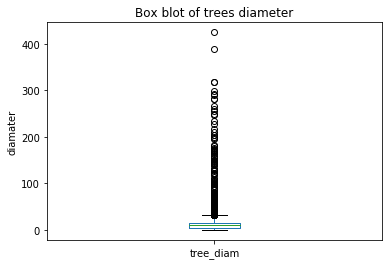

In [14]:
df.tree_diam.plot(kind='box')
plt.title('Box blot of trees diameter')
plt.ylabel('diamater')

In [15]:
df.groupby('borough')['tree_diam'].max()

borough
Bronx            291
Brooklyn         425
Manhattan        318
Queens           389
Staten Island    298
Name: tree_diam, dtype: int64

In [16]:
df.groupby('species')['tree_diam'].max().sort_values(ascending=False)

species
swamp white oak          425
tulip-poplar             389
London planetree         318
pin oak                  318
Callery pear             298
cherry                   291
littleleaf linden        266
mulberry                 217
Japanese zelkova         210
Norway maple             204
willow oak               199
black locust             177
crimson king maple       172
honeylocust              169
silver maple             168
green ash                159
red maple                154
Siberian elm             149
Sophora                  141
sweetgum                 128
Chinese elm              118
ginkgo                   106
eastern redcedar          99
Schumard's oak            91
Atlantic white cedar      89
northern red oak          76
American elm              65
black oak                 64
crab apple                64
eastern cottonwood        64
                        ... 
European alder            29
kousa dogwood             28
serviceberry              28
paper 

In [17]:
df.groupby('species')['tree_diam'].median().sort_values(ascending=False)[:20]

species
London planetree      22.0
silver maple          21.0
pin oak               17.0
eastern cottonwood    16.0
horse chestnut        15.0
pignut hickory        15.0
weeping willow        14.0
Norway maple          14.0
sycamore maple        14.0
ash                   13.0
catalpa               13.0
green ash             13.0
white ash             12.0
mulberry              11.0
white pine            11.0
sugar maple           11.0
maple                 11.0
tree of heaven        11.0
black locust          11.0
willow oak            10.0
Name: tree_diam, dtype: float64

In [18]:
df.groupby('species')['tree_diam'].mean().sort_values(ascending=False)[:20]

species
London planetree      21.560900
silver maple          21.017927
eastern cottonwood    17.061594
pin oak               16.867053
weeping willow        15.797872
pignut hickory        15.393939
sycamore maple        14.767118
Norway maple          14.330516
catalpa               14.284936
mulberry              14.219533
horse chestnut        14.015511
ash                   13.684553
green ash             13.566338
white ash             12.672614
tree of heaven        12.664021
white pine            12.569307
willow oak            12.279209
black locust          12.192825
American elm          11.953229
sassafras             11.807018
Name: tree_diam, dtype: float64

In [19]:
# Diameter values above 100 are suspicious. They are reported across all boroughs and for more than 1 species.
# It is considered a typo or wrong entry. 
# A threshold of 90 is used to filter, the entries above this value are removed, since they are a small percentage
# of the data.
df_tree=df[df['tree_diam']<=90]
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652044 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652044 non-null object
tree_diam     652044 non-null int64
curb_loc      652044 non-null object
health        652044 non-null object
species       652044 non-null object
steward       652044 non-null object
guards        652044 non-null object
sidewalk      652044 non-null object
user_type     652044 non-null object
problems      652044 non-null object
root_stone    652044 non-null object
root_grate    652044 non-null object
root_other    652044 non-null object
trunk_wire    652044 non-null object
trnk_light    652044 non-null object
trnk_other    652044 non-null object
brch_light    652044 non-null object
brch_shoe     652044 non-null object
brch_other    652044 non-null object
borocode      652044 non-null int64
borough       652044 non-null object
nta_name      652044 non-null object
latitude      652044 non-null float64
longitude     652044 non-null float64
d

In [20]:
#df_tree[df_tree.duplicated(['species','tree_diam','created_at'])]
df_tree[df_tree.duplicated()]

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
62722,09/16/2015,28,OnCurb,Good,London planetree,None,None,Damage,TreesCount Staff,Stones,...,No,No,No,No,No,3,Brooklyn,Midwood,40.615966,-73.956801
184923,10/26/2015,3,OnCurb,Good,sawtooth oak,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Woodside,40.748463,-73.910383
271605,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693128,-73.986285
273114,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693094,-73.985292
276682,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278174,12/04/2015,12,OnCurb,Good,Callery pear,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278356,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278413,12/04/2015,6,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278459,12/04/2015,9,OnCurb,Good,pin oak,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278500,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861


In [21]:
df_tree.drop_duplicates()
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652044 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652044 non-null object
tree_diam     652044 non-null int64
curb_loc      652044 non-null object
health        652044 non-null object
species       652044 non-null object
steward       652044 non-null object
guards        652044 non-null object
sidewalk      652044 non-null object
user_type     652044 non-null object
problems      652044 non-null object
root_stone    652044 non-null object
root_grate    652044 non-null object
root_other    652044 non-null object
trunk_wire    652044 non-null object
trnk_light    652044 non-null object
trnk_other    652044 non-null object
brch_light    652044 non-null object
brch_shoe     652044 non-null object
brch_other    652044 non-null object
borocode      652044 non-null int64
borough       652044 non-null object
nta_name      652044 non-null object
latitude      652044 non-null float64
longitude     652044 non-null float64
d

In [22]:
df_tree.reset_index(drop=True,inplace=True)
df_tree.tail()

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
652039,08/18/2015,25,OnCurb,Good,pin oak,None,None,Damage,Volunteer,None,...,No,No,No,No,No,3,Brooklyn,North Side-South Side,40.713211,-73.954944
652040,08/29/2015,7,OnCurb,Good,Kentucky yellowwood,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Forest Hills,40.715194,-73.856650
652041,08/22/2015,12,OnCurb,Good,red maple,None,None,Damage,Volunteer,None,...,No,No,No,No,No,5,Staten Island,Westerleigh,40.620762,-74.136517
652042,08/29/2015,9,OnCurb,Good,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,2,Bronx,Mount Hope,40.850828,-73.903115
652043,09/03/2015,23,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,4,Queens,Fresh Meadows-Utopia,40.732165,-73.787526


EXPLORE DATA

Plot trees health and count vs location and other features (for example position, steward).

In [23]:
# Set color palette for plots as 'colorblind'
bcol=sns.color_palette('colorblind').as_hex()
sns.set_palette("colorblind")

Text(0, 0.5, 'Count')

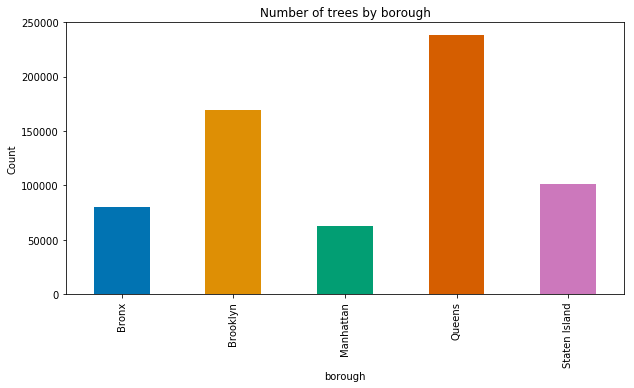

In [24]:
df_tree.groupby('borough')['tree_diam'].count().plot(kind='bar',color=bcol,figsize=(10,5))
plt.title('Number of trees by borough')
plt.ylabel('Count')

The first plot already shows something interesting: the highest numerb of tress isn't in Manhattan, where Central Park is located, but in Queens! Manhattan has the lowest number of trees.

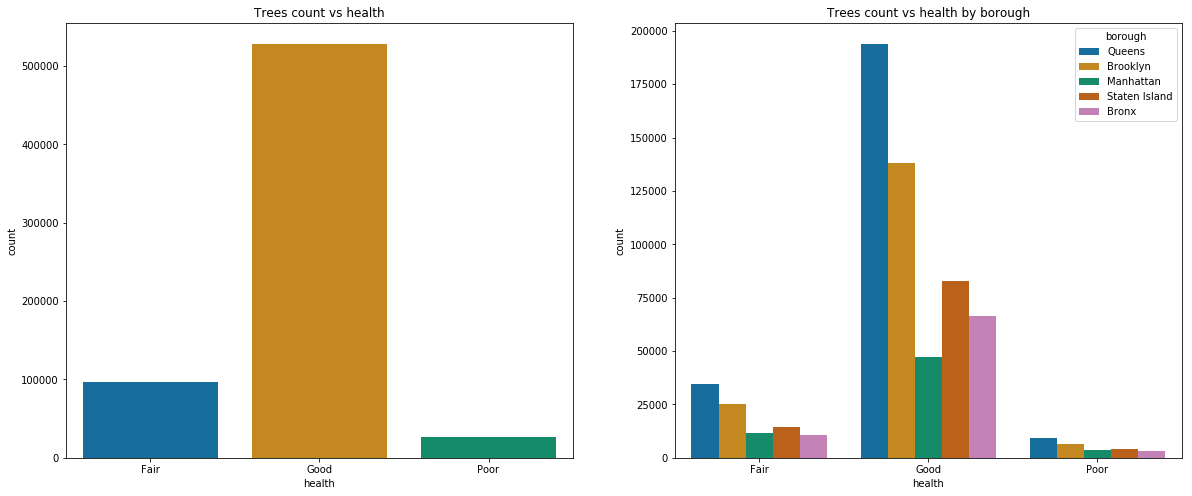

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", data=df_tree,ax=axes[0])
axes[0].set_title('Trees count vs health')
sns.catplot(x="health", kind="count", hue='borough',data=df_tree,ax=axes[1])
axes[1].set_title('Trees count vs health by borough')
plt.close(2)
plt.close(3)

The data set is skewed towards the "good" health, so it will probably need to be balanced when creating a predictive model.
This is true if both looking at the overall trees' count and by borough. It is also confirmed by the fact that the order of borough by trees count is the same, reagrdless of health.  

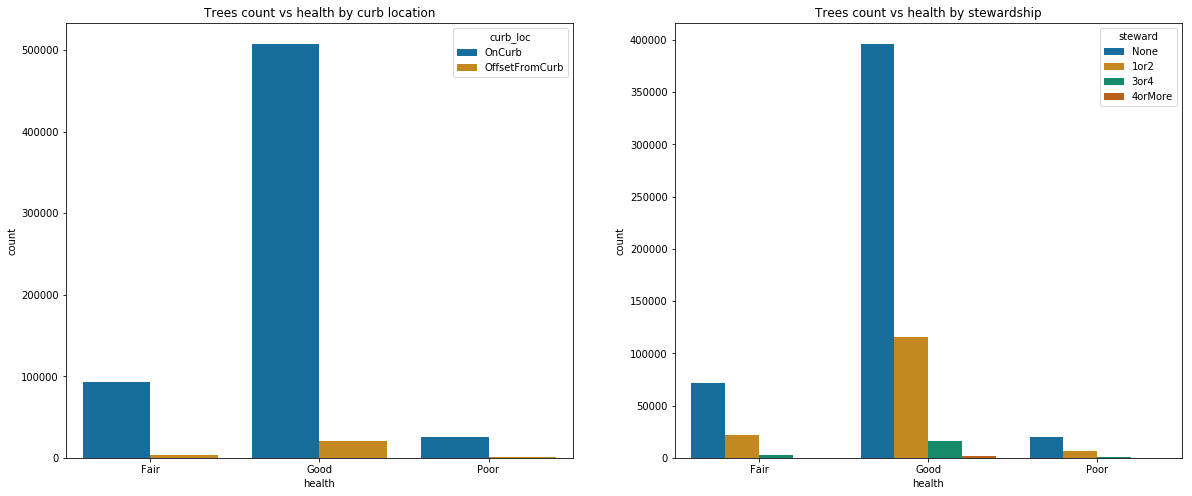

In [26]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", hue='curb_loc', data=df_tree,ax=axes1[0])
axes1[0].set_title('Trees count vs health by curb location')
sns.catplot(x="health", kind="count", hue='steward', data=df_tree,ax=axes1[1])
axes1[1].set_title('Trees count vs health by stewardship')
plt.close(3)
plt.close(2)

Text(0.5, 1.0, 'Trees count vs user type and health')

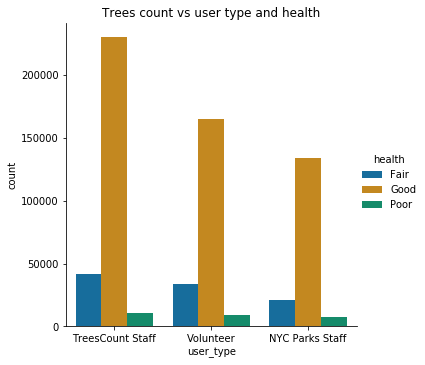

In [27]:
sns.catplot(x="user_type", kind="count", hue='health', data=df_tree)
plt.title('Trees count vs user type and health')

The fact that trees have been attended to or not, and by whom, volunteers or staff, doesn't affect the health status. The trends are confirmed. 

Plot trees' diameter vs location, health.

In [28]:
# Plot diameter vs borough and health after grouping and applying custom function
bor_group=df_tree.groupby('borough')
bor_list=list(bor_group.groups.keys())
health_group=df_tree.groupby('health')
health_list=list(health_group.groups.keys())

def avg_diam(group):
    diam=[group['tree_diam'].mean().round(1) for k,group in group]
    return(diam)

Text(0, 0.5, 'Diameter')

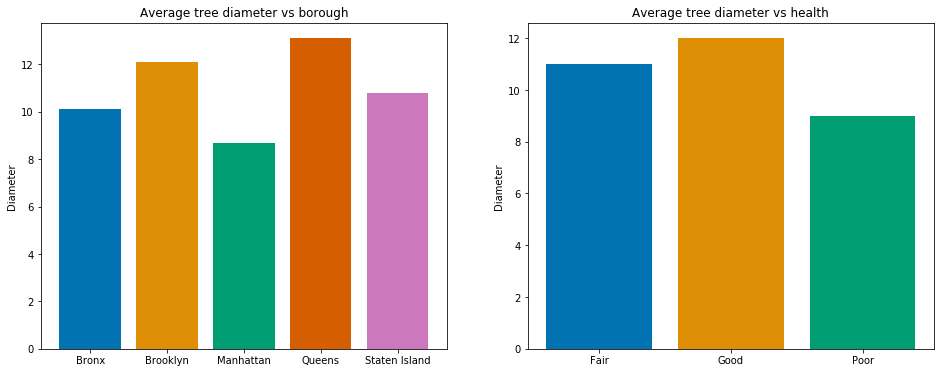

In [29]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.bar(range(len(bor_group.groups)),avg_diam(bor_group),tick_label=bor_list,color=bcol)
plt.title('Average tree diameter vs borough')
plt.ylabel('Diameter')
plt.subplot(1,2,2)
plt.bar(range(len(health_group.groups)),avg_diam(health_group),tick_label=health_list,color=bcol)
plt.title('Average tree diameter vs health')
plt.ylabel('Diameter')

The trees diameter plots show a couple of interesting results. The diameter follows the order of the borough by number of individuals: where there are more trees, their diameter is also bigger. Furthermore, there's a possible correlation between the diameter and the health: helthiest trees seem to have bigger diameters. The latter finding suggest the diameter is a variable to use when building the model.

A different view at trees' diameter and number vs borough and health.

In [30]:
df_hbd=df_tree[['health','borough','tree_diam']].groupby(['health','borough'])
df_hbd.groups.keys()

dict_keys([('Fair', 'Bronx'), ('Fair', 'Brooklyn'), ('Fair', 'Manhattan'), ('Fair', 'Queens'), ('Fair', 'Staten Island'), ('Good', 'Bronx'), ('Good', 'Brooklyn'), ('Good', 'Manhattan'), ('Good', 'Queens'), ('Good', 'Staten Island'), ('Poor', 'Bronx'), ('Poor', 'Brooklyn'), ('Poor', 'Manhattan'), ('Poor', 'Queens'), ('Poor', 'Staten Island')])

In [31]:
hl=[]
bl=[]
cl=[]
dl=[]
for name,group in df_hbd: 
    print(name,len(group.index), group['tree_diam'].mean().round(1))
    hl.append(name[0])
    bl.append(name[1])
    cl.append(len(group.index))
    dl.append(group['tree_diam'].mean().round(1))

('Fair', 'Bronx') 10885 9.2
('Fair', 'Brooklyn') 25067 11.3
('Fair', 'Manhattan') 11457 8.1
('Fair', 'Queens') 34540 12.6
('Fair', 'Staten Island') 14533 10.2
('Good', 'Bronx') 66592 10.3
('Good', 'Brooklyn') 138186 12.5
('Good', 'Manhattan') 47351 9.0
('Good', 'Queens') 193987 13.3
('Good', 'Staten Island') 82635 11.0
('Poor', 'Bronx') 3094 7.6
('Poor', 'Brooklyn') 6457 8.7
('Poor', 'Manhattan') 3609 6.8
('Poor', 'Queens') 9415 10.7
('Poor', 'Staten Island') 4236 8.7


In [32]:
d={'health': hl, 'borough': bl, 'trees_num': cl, 'avg_diam':dl}
nd=pd.DataFrame(d)
nd

,health,borough,trees_num,avg_diam
0,Fair,Bronx,10885,9.2
1,Fair,Brooklyn,25067,11.3
2,Fair,Manhattan,11457,8.1
3,Fair,Queens,34540,12.6
4,Fair,Staten Island,14533,10.2
5,Good,Bronx,66592,10.3
6,Good,Brooklyn,138186,12.5
7,Good,Manhattan,47351,9.0
8,Good,Queens,193987,13.3
9,Good,Staten Island,82635,11.0


In [33]:
nd['trees_norm']=(nd['trees_num']-nd['trees_num'].min())/(nd['trees_num'].max()-nd['trees_num'].min())
nd['diam_norm']=(nd['avg_diam']-nd['avg_diam'].min())/(nd['avg_diam'].max()-nd['avg_diam'].min())
nd

,health,borough,trees_num,avg_diam,trees_norm,diam_norm
0,Fair,Bronx,10885,9.2,0.040813,0.369231
1,Fair,Brooklyn,25067,11.3,0.115106,0.692308
2,Fair,Manhattan,11457,8.1,0.043810,0.200000
3,Fair,Queens,34540,12.6,0.164731,0.892308
4,Fair,Staten Island,14533,10.2,0.059924,0.523077
5,Good,Bronx,66592,10.3,0.332637,0.538462
6,Good,Brooklyn,138186,12.5,0.707684,0.876923
7,Good,Manhattan,47351,9.0,0.231842,0.338462
8,Good,Queens,193987,13.3,1.000000,1.000000
9,Good,Staten Island,82635,11.0,0.416678,0.646154


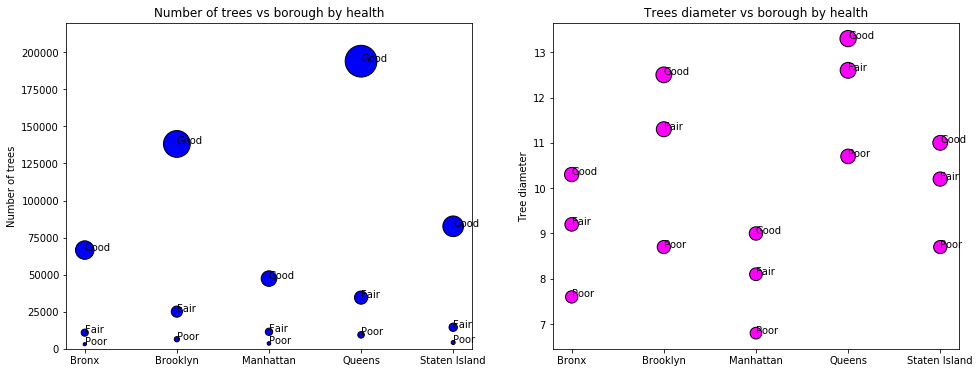

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(nd.borough,nd['trees_num'], s = nd['trees_norm']*1000+10, c='blue', linewidths=1,edgecolors='k') 
plt.title('Number of trees vs borough by health')
plt.ylabel('Number of trees')
plt.ylim([0,220000])
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['trees_num'][i]))
plt.subplot(1,2,2)
plt.scatter(nd.borough,nd['avg_diam'],  s = nd['avg_diam']*20, c='magenta', linewidths=1, edgecolors='k') 
plt.title('Trees diameter vs borough by health')
plt.ylabel('Tree diameter')
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['avg_diam'][i]))    

Another look at the diameter vs health and borough reveals that the same diameter is an indication of a different health, depending on where the tree is located. This suggest that it may be appropriate to apply the model separately to the different boroughs.

Analyses of species.

In [35]:
# Create separate dataframes for the different boroughs. Visualize most common species.
#bor_list=list(df_tree.borough.unique())
bor_list

['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

In [37]:
def bordf(df,name):
    df_bor=df[df.borough==name]
    df_bor.reset_index(drop=True,inplace=True)
    return(df_bor)
df_queens=bordf(df_tree,'Queens')  
df_brook=bordf(df_tree,'Brooklyn')  
df_manh=bordf(df_tree,'Manhattan') 
df_state=bordf(df_tree,'Staten Island') 
df_bronx=bordf(df_tree,'Bronx') 

Text(0.5, 0, 'Count')

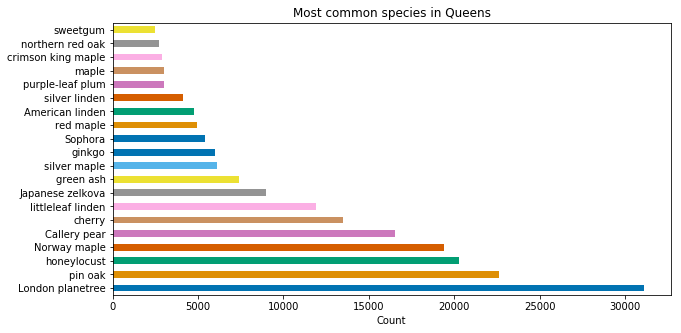

In [38]:
df_queens.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Queens')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

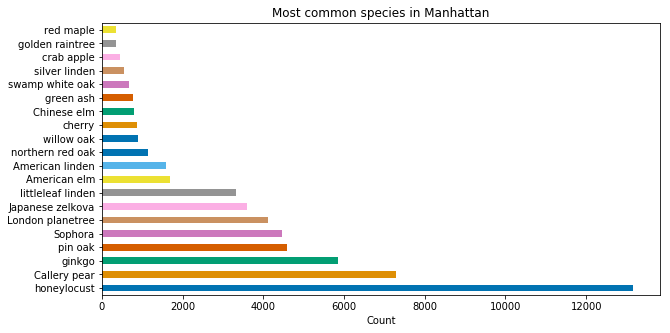

In [39]:
df_manh.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Manhattan')
plt.xlabel('Count')

Although the number of trees in Queens and Manhanttan is quite different, they have some species in common. Maybe the difference is due to a different area. A quick check confirmed that Queen's land areas is approximately 5 times Manhattan's.

TEXT TO NUMERICAL CONVERSION

In [40]:
# Create a function to use for conversion of text data to numerical.
def label_enc(series):
    series=series.astype('category')
    new_series=series.cat.codes
    return(new_series)

# list of features to be converted
enc_list=['curb_loc', 'health','steward',
       'guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

# Apply function to dataframe
df_text=df_tree[enc_list].copy()
df_text_enc=df_text.transform(label_enc)

df_text_noenc=df_tree.copy()
df_text_noenc.drop(enc_list,axis=1,inplace=True)

df_tree_enc=pd.concat([df_text_noenc,df_text_enc], axis=1)

In [41]:
df_tree_enc.head()

,created_at,tree_diam,species,problems,borocode,borough,nta_name,latitude,longitude,curb_loc,...,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,08/27/2015,3,red maple,None,4,Queens,Forest Hills,40.723092,-73.844215,1,...,1,0,0,0,0,0,0,0,0,0
1,09/03/2015,21,pin oak,Stones,4,Queens,Whitestone,40.794111,-73.818679,1,...,1,1,0,0,0,0,0,0,0,0
2,09/05/2015,3,honeylocust,None,3,Brooklyn,East Williamsburg,40.717581,-73.936608,1,...,2,0,0,0,0,0,0,0,0,0
3,09/05/2015,10,honeylocust,Stones,3,Brooklyn,East Williamsburg,40.713537,-73.934456,1,...,2,1,0,0,0,0,0,0,0,0
4,08/30/2015,21,American linden,Stones,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979,1,...,2,1,0,0,0,0,0,0,0,0
